In [1]:
import pandas as pd
import numpy as np
import time 
import seaborn as sb
import matplotlib as plt
import sklearn as sk
import vectorbt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import torch
import re
import math

Preprocessing


In [2]:
import yfinance as yf
import pandas as pd
import os
import time
import numpy as np

def clean_existing_data(filename):
    """Loads and cleans existing CSV before fetching new data, removing corrupted rows automatically."""
    if not os.path.exists(filename):
        print("📂 No existing file found. Creating a new one.")
        return None  # No existing data

    print("🧹 Cleaning existing data...")

    try:
        df = pd.read_csv(filename, on_bad_lines="skip")  # ✅ Skip corrupted lines
    except pd.errors.ParserError:
        print("⚠️ ParserError detected! Attempting alternative cleanup.")
        with open(filename, "r", encoding="utf-8") as file:
            lines = file.readlines()

        # ✅ Keep only correctly formatted rows (same number of commas as the header)
        valid_lines = [line for line in lines if line.count(",") == lines[0].count(",")]

        with open(filename, "w", encoding="utf-8") as file:
            file.writelines(valid_lines)

        df = pd.read_csv(filename)  # ✅ Reload clean file

    # ✅ Remove rows where ALL stock values (except Date) are NaN (pre-IPO periods)
    df_cleaned = df.dropna(subset=df.columns[1:], how='all')

    # ✅ Remove duplicate dates (if any)
    df_cleaned = df_cleaned.drop_duplicates(subset=["Date"])

    # ✅ Save cleaned data back to file
    df_cleaned.to_csv(filename, index=False)
    print(f"✅ Cleaned data saved to {filename}. Total tickers: {len(df_cleaned.columns)-1}")

    return df_cleaned  # Return cleaned dataframe

def download_stock_data(tickers, start_date, end_date, filename="data.csv", batch_size=10, delay_range=(5, 15), max_retries=3):
    """
    Downloads stock price data and fundamental data from Yahoo Finance in batches while:
    - Avoiding duplicate downloads
    - Handling API rate limits and retries
    - Keeping raw data structure consistent with Yahoo Finance
    """
    
    # ✅ Step 1: Clean existing data before fetching new data
    existing_df = clean_existing_data(filename)
    
    all_data = []
    fundamentals_data = []
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"📥 Downloading batch: {batch}")

        for attempt in range(max_retries):
            try:
                # ✅ Download price data
                df = yf.download(batch, start=start_date, end=end_date, group_by='ticker')
                batch_data = []
                
                for ticker in batch:
                    if ticker in df:
                        stock_df = df[ticker].copy()
                        stock_df.insert(0, 'Ticker', ticker)  # Add Ticker column
                        batch_data.append(stock_df)
                
                all_data.extend(batch_data)
                
                # ✅ Fetch fundamental data for each stock
                for ticker in batch:
                    stock = yf.Ticker(ticker)
                    info = stock.info
                    
                    fundamentals_data.append({
                        "Ticker": ticker,
                        "Beta": info.get("beta"),
                        "EPS": info.get("trailingEps"),
                        "MarketCap": info.get("marketCap"),
                        "PE Ratio": info.get("trailingPE"),
                        "Volatility": info.get("52WeekChange"),
                        "Dividend Yield": info.get("dividendYield"),
                        "Profit Margins": info.get("profitMargins"),
                        "Return on Assets": info.get("returnOnAssets"),
                        "Return on Equity": info.get("returnOnEquity"),
                        "Current Ratio": info.get("currentRatio"),
                        "Quick Ratio": info.get("quickRatio"),
                        "Debt to Equity": info.get("debtToEquity"),
                        "Revenue": info.get("totalRevenue"),
                        "Gross Profits": info.get("grossProfits"),
                        "Operating Margins": info.get("operatingMargins"),
                    })
                
                print(f"✅ Batch {batch} downloaded.")
                break  # Success, move to next batch
            except Exception as e:
                print(f"⚠️ Error downloading {batch} (Attempt {attempt+1}/{max_retries}): {e}")
                time.sleep(5)  # Short wait before retry
        else:
            print(f"❌ Failed to download {batch} after {max_retries} attempts. Skipping.")

        # ✅ Random delay to avoid API bans
        time.sleep(np.random.randint(*delay_range))
    
    # ✅ Combine price data
    if all_data:
        price_data = pd.concat(all_data, axis=0).reset_index()
    
    # ✅ Convert fundamentals data to DataFrame
    fundamentals_df = pd.DataFrame(fundamentals_data)
    
    # ✅ Merge price & fundamental data
    price_data = price_data.reset_index()  # Flatten any MultiIndex before merging
    final_data = price_data.merge(fundamentals_df, on="Ticker", how="left") if not fundamentals_df.empty else price_data
    
    # ✅ Save to file
    final_data.to_csv(filename, index=False)
    print(f"✅ Data saved to {filename}")
    
    return final_data


In [3]:
def load_data(filepath):
    """Loads and reshapes the data into a structured format with fundamental and price data."""
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Ensure numeric columns
    price_cols = ["Close", "Open", "High", "Low", "Volume"]
    fundamental_cols = ["Beta", "EPS", "MarketCap", "PE Ratio", "Volatility", "Dividend Yield", 
                        "Profit Margins", "Return on Assets", "Return on Equity", "Current Ratio", 
                        "Quick Ratio", "Debt to Equity", "Revenue", "Gross Profits", "Operating Margins"]
    
    for col in price_cols + fundamental_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Remove rows before first valid entry per ticker
    df.dropna(subset=["Close"], inplace=True)

    # Sort and fill missing values per ticker
    df.sort_values(by=["Ticker", "Date"], inplace=True)
    df = df.groupby("Ticker", group_keys=False).apply(lambda group: group.fillna(method="ffill")).reset_index(drop=True)
    df = df.groupby("Ticker", group_keys=False).apply(lambda group: group.fillna(method="bfill")).reset_index(drop=True)
    
    return df


In [4]:
tickers = [
    # Tech Giants (Success Stories)
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "IBM", "ORCL", "CRM", "AMD",
    
    # Healthcare (Pharma, Biotech, Medical Devices)
    "JNJ", "PFE", "MRK", "UNH", "BMY", "REGN", "LLY", "GILD", "ISRG", "VRTX", 
    
    # Finance (Banks, Insurance, Investment Firms)
    "JPM", "BAC", "GS", "WFC", "MS", "C", "AXP", "BLK", "TROW", "SCHW", 
    
    # Consumer Goods & Retail (Big Players + Struggled Companies)
    "TSLA", "NKE", "HD", "MCD", "KO", "PG", "PEP", "COST", "WMT", "SBUX",  
    "BBY", "TGT", "LOW", "TJX", "WBA", "KR", "CVS", "DG", "YUM", "DASH",  
    
    # Energy (Oil, Renewables)
    "XOM", "CVX", "BP", "ENB", "DUK", "OXY", "FSLR", "RUN", "PLUG", "NEE",  
    
    # Industrials (Aerospace, Defense, Construction)
    "BA", "CAT", "LMT", "GE", "HON", "DE", "NOC", "MMM", "RTX", "FDX",  
    
    # Media & Entertainment
    "DIS", "NFLX", "T", "VZ", "CMCSA", "RBLX", "SPOT", "EA", "TTWO", "FOX",  
    
    # Failed/Declining Companies (Bankruptcies, Massive Falls)
    "SVB", "LEH", "FRCB", "BBBY", "RAD", "JCP", "SHLDQ", "FTX", "CCL", "RIDE",  
    
    # Small-Cap Growth Stocks & Speculative Plays
    "PLTR", "SOFI", "AFRM", "RIVN", "LCID", "NKLA", "UPST", "PATH", "BMBL", "COIN",  
    
    # Semiconductor & Hardware
    "INTC", "TSM", "MU", "QCOM", "AVGO", "TXN", "NXPI", "LRCX", "ASML", "STX",  
    
    # Automakers (Traditional & EV)
    "GM", "F", "RACE", "NIO", "XPEV", "LI", "FSR", "BYDDF", "STLA", "HMC",  
    
    # Food & Agriculture
    "ADM", "BG", "KHC", "TSN", "MDLZ", "SJM", "GIS", "HRL", "LANC", "CAG",  
    
    # Real Estate (REITs)
    "PLD", "O", "SPG", "EQIX", "AVB", "MAA", "EQR", "ESS", "VTR", "PEAK",  
    
    # Payment Processors & Fintech
    "V", "MA", "PYPL", "SQ", "ADYEY", "FIS", "FISV", "FLT", "GPN", "AFRM"
]



In [5]:
import pandas as pd

def compute_momentum_features(df):
    """Computes past-only rolling averages efficiently, ensuring no future data leakage."""
    
    if df is None or df.empty:
        raise ValueError("DataFrame is None or empty. Check data loading step.")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Ticker", "Date"])  # ✅ Ensure correct sorting

    # ✅ Compute 5-day percentage change (momentum signal)
    df["Pct_Change"] = df.groupby("Ticker")["Close"].pct_change(periods=5)

    # ✅ Create target variable: stock moves up (1) or down (0) after 5 days
    df["Target"] = df.groupby("Ticker")["Pct_Change"].shift(-5) > 0
    df["Target"] = df["Target"].astype(int)  # Convert Boolean to int

    # ✅ Compute rolling averages (past-only, preventing data leakage)
    rolling_windows = [20, 50, 100]
    for window in rolling_windows:
        df[f"Rolling_Avg_{window}"] = (
            df.groupby("Ticker")["Pct_Change"]
            .transform(lambda x: x.rolling(window, min_periods=5).mean())  # Prevent NaN explosion
            .shift(1)  # Shift to avoid data leakage
        )

    # ✅ Only drop rows where `Target` or `Pct_Change` is NaN
    print(f"Before dropna: {df.shape}")  # Debugging
    df = df.dropna(subset=["Target", "Pct_Change"])
    print(f"After dropna: {df.shape}")  # Debugging

    return df


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer

def normalize_all_stocks_together(train_df, val_df, test_df):
    """
    Normalizes stock data using StandardScaler with appropriate transformations.
    - Fits only on training data to prevent data leakage.
    - Clips extreme values for robustness.
    - Applies log transformation to Volume.
    - Uses Yeo-Johnson transformation for Pct_Change.
    - Standardizes all relevant features.
    """

    # ✅ Define all relevant features for scaling & transformation
    fundamental_features = [
        "Beta", "EPS", "MarketCap", "PE Ratio", "Volatility", "Dividend Yield", "Profit Margins",
        "Return on Assets", "Return on Equity", "Current Ratio", "Quick Ratio", "Debt to Equity",
        "Revenue", "Gross Profits", "Operating Margins"
    ]
    momentum_features = ["Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100"]
    market_features = ["Volume", "Pct_Change"]
    
    key_features = fundamental_features + momentum_features + market_features
    
    # ✅ Ensure datasets are sorted before processing
    for df in [train_df, val_df, test_df]:
        df.sort_values(["Ticker", "Date"], inplace=True)

    # ✅ Replace infinite values with NaN
    for df in [train_df, val_df, test_df]:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # ✅ Clip extreme values in Pct_Change to avoid high variance
    clip_threshold_low = train_df["Pct_Change"].quantile(0.01)
    clip_threshold_high = train_df["Pct_Change"].quantile(0.99)
    for df in [train_df, val_df, test_df]:
        df.loc[:, "Pct_Change"] = df["Pct_Change"].clip(clip_threshold_low, clip_threshold_high)

    # ✅ Apply log transformation to Volume (ensuring no negatives)
    for df in [train_df, val_df, test_df]:
        df.loc[:, "Volume"] = np.log1p(np.maximum(df["Volume"], 0))  

    # ✅ Forward-fill missing values per Ticker (avoids leakage)
    for df in [train_df, val_df, test_df]:
        df.loc[:, key_features] = df.groupby("Ticker")[key_features].ffill()

    # ✅ Drop NaNs AFTER forward-filling (ensures valid samples)
    for df in [train_df, val_df, test_df]:
        df.dropna(subset=key_features, inplace=True)

    # ✅ Apply Yeo-Johnson transformation to `Pct_Change`
    pt = PowerTransformer(method="yeo-johnson")
    train_df.loc[:, "Pct_Change"] = pt.fit_transform(train_df[["Pct_Change"]])
    val_df.loc[:, "Pct_Change"] = pt.transform(val_df[["Pct_Change"]])
    test_df.loc[:, "Pct_Change"] = pt.transform(test_df[["Pct_Change"]])

    # ✅ Fit StandardScaler ONLY on training data
    scaler = StandardScaler()
    scaler.fit(train_df[key_features])

    # ✅ Apply scaling to all datasets
    for df in [train_df, val_df, test_df]:
        df.loc[:, key_features] = scaler.transform(df[key_features])

    return train_df, val_df, test_df, scaler



In [7]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

import pandas as pd
import numpy as np

def split_data(df):
    df["Date"] = pd.to_datetime(df["Date"])  # Ensure date column is datetime

    min_date, max_date = df["Date"].min(), df["Date"].max()
    total_range = (max_date - min_date).days
    print(f"📅 Date range: {min_date} → {max_date} ({total_range} days)")

    # Allocate ~50% of data to train, 25% to val, 25% to test
    train_end = min_date + pd.Timedelta(days=int(total_range * 0.5))
    val_end = train_end + pd.Timedelta(days=int(total_range * 0.25))

    print(f"📊 Splitting periods:")
    print(f"   🏋 Train: {min_date} → {train_end}")
    print(f"   🧪 Val: {train_end + pd.Timedelta(days=1)} → {val_end}")
    print(f"   📊 Test: {val_end + pd.Timedelta(days=1)} → {max_date}")

    # Apply date-based filtering
    train_df = df[df["Date"] <= train_end]
    val_df = df[(df["Date"] > train_end) & (df["Date"] <= val_end)]
    test_df = df[df["Date"] > val_end]

    print(f"📈 Final Shapes: Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

    return train_df, val_df, test_df


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def validate_preprocessed_data(train_df, val_df, test_df):
    """
    Performs comprehensive checks on preprocessed financial time-series data
    to ensure correctness before feeding it into a Transformer model.
    """

    print("\n📌 Checking Data Integrity...\n")
    print(train_df.head())
    print(train_df.info())
    print(train_df.describe())

    # Check for missing values
    print("\n🔍 Missing Values (should be 0 for key features):")
    print(train_df.isnull().sum())

    # Ensure column names are correct
    expected_columns = ["Date", "Ticker", "Close", "Open", "High", "Low", "Volume", 
                        "Pct_Change", "Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100"]
    missing_columns = [col for col in expected_columns if col not in train_df.columns]
    if missing_columns:
        print(f"❌ Missing expected columns: {missing_columns}")
    else:
        print("✅ All expected columns are present.")

    print("\n📌 Checking Data Splitting...\n")
    print(f"Train: {train_df['Date'].min()} to {train_df['Date'].max()}, {train_df['Ticker'].nunique()} tickers")
    print(f"Validation: {val_df['Date'].min()} to {val_df['Date'].max()}, {val_df['Ticker'].nunique()} tickers")
    print(f"Test: {test_df['Date'].min()} to {test_df['Date'].max()}, {test_df['Ticker'].nunique()} tickers")

    # Ensure no data leakage across sets
    overlap = set(train_df["Ticker"]) & set(val_df["Ticker"]) & set(test_df["Ticker"])
    if overlap:
        print(f"⚠️ Warning: {len(overlap)} tickers appear in multiple sets: {overlap}")
    else:
        print("✅ No data leakage between train/val/test splits.")

    print("\n📌 Checking Momentum Features...\n")
    print(train_df[["Ticker", "Date", "Pct_Change", "Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100"]].head(10))

    # Check for data leakage in rolling averages
    def check_leakage(group):
        return group["Rolling_Avg_20"].iloc[0]  # First value should be NaN for new tickers

    leakage_check = train_df.groupby("Ticker").apply(check_leakage).isnull().all()
    if leakage_check:
        print("✅ No future data leakage in momentum features.")
    else:
        print("❌ Possible data leakage detected in rolling averages!")

    print("\n📌 Checking Normalization & Scaling...\n")

    # Check if normalization worked (mean ≈ 0, std ≈ 1)
    key_features = ["Pct_Change", "Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100", "Volume"]
    means = train_df[key_features].mean()
    stds = train_df[key_features].std()
    
    print("\nFeature Means (should be close to 0):")
    print(means)
    print("\nFeature Standard Deviations (should be close to 1):")
    print(stds)

    # Check for infinite values
    if np.isinf(train_df).sum().sum() > 0:
        print("❌ Warning: Infinite values detected in train set!")
    else:
        print("✅ No infinite values found.")

    # Plot distributions to verify transformations
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(train_df["Pct_Change"], bins=100, ax=axes[0], kde=True).set_title("Pct_Change After Normalization")
    sns.histplot(train_df["Volume"], bins=100, ax=axes[1], kde=True).set_title("Volume After Log Transform")
    plt.show()

    print("\n✅ All checks complete. If no warnings appeared, the dataset is ready for training!\n")


In [9]:
# 1️⃣ Load Data
'''datav2 = download_stock_data(tickers, "1980-01-01", "2024-01-01",filename="data2.csv", delay_range=(5, 15), max_retries=3)'''

df = load_data("data2.csv")

df.head()
df.drop(columns=["Adj Close"], inplace=True)
# 3️⃣ Split Data First (Prevents Future Leakage)
train_df, val_df, test_df = split_data(df)
# 4️⃣ Compute Momentum Features AFTER Splitting
train_df = compute_momentum_features(train_df)
val_df = compute_momentum_features(val_df)
test_df = compute_momentum_features(test_df)


train_df, val_df, test_df, scaler = normalize_all_stocks_together(train_df, val_df, test_df)


C:\Users\anton\AppData\Local\Temp\ipykernel_19928\3514676975.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.groupby("Ticker", group_keys=False).apply(lambda group: group.fillna(method="ffill")).reset_index(drop=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_19928\3514676975.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Ticker", group_keys=False).apply(lambda group: group.fillna(method="ffill")).reset_index(drop=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_19928\3514676975.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a fut

📅 Date range: 1980-01-02 00:00:00 → 2023-12-29 00:00:00 (16067 days)
📊 Splitting periods:
   🏋 Train: 1980-01-02 00:00:00 → 2001-12-30 00:00:00
   🧪 Val: 2001-12-31 00:00:00 → 2012-12-28 00:00:00
   📊 Test: 2012-12-29 00:00:00 → 2023-12-29 00:00:00
📈 Final Shapes: Train: (565082, 23), Val: (562152, 23), Test: (725147, 23)
Before dropna: (565082, 28)
After dropna: (564587, 28)
Before dropna: (562152, 28)
After dropna: (561577, 28)
Before dropna: (725147, 28)
After dropna: (724452, 28)



📊 Checking Train dataset:
Mean (should be ~0):
Pct_Change           1.762209e-18
Rolling_Avg_20       1.180989e-17
Rolling_Avg_50      -1.218088e-17
Rolling_Avg_100     -1.556927e-16
Volume              -1.029130e-15
Beta                -2.898679e-16
EPS                  1.268790e-16
MarketCap            1.607629e-17
PE Ratio             9.658142e-17
Volatility           1.540851e-16
Dividend Yield       1.173878e-16
Profit Margins      -2.671138e-16
Return on Assets     7.902116e-17
Return on Equity    -6.529448e-17
Current Ratio        3.316663e-16
Quick Ratio         -2.873946e-16
Debt to Equity      -1.664515e-16
Revenue             -3.957241e-17
Gross Profits        2.473276e-18
Operating Margins    1.187172e-17
dtype: float64
Std (should be ~1):
Pct_Change           1.000001
Rolling_Avg_20       1.000001
Rolling_Avg_50       1.000001
Rolling_Avg_100      1.000001
Volume               1.000001
Beta                 1.000001
EPS                  1.000001
MarketCap            1.0000

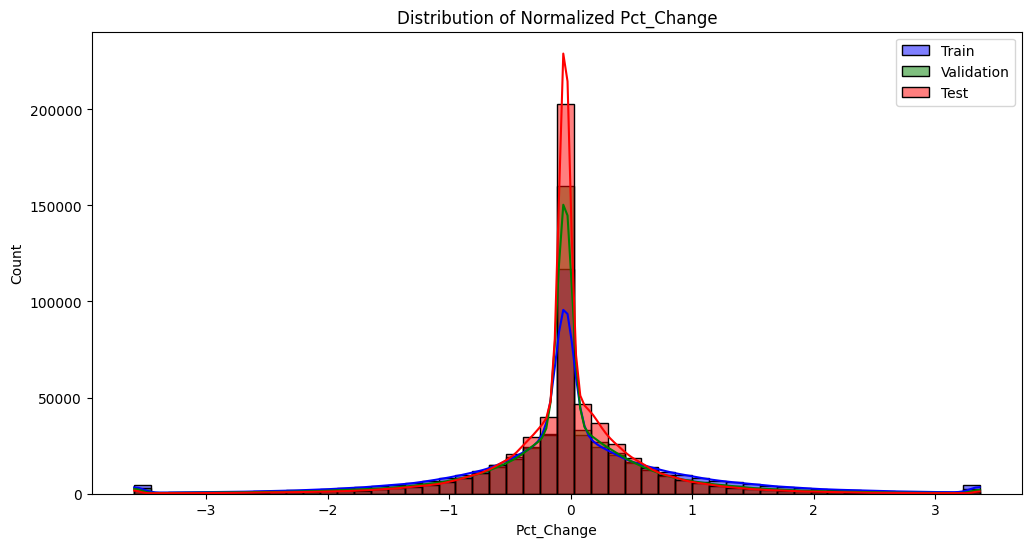

✅ Normalization Test Completed Successfully!


In [10]:
def test_normalization(train_df, val_df, test_df, scaler, features):
    """
    Tests the normalization process by checking:
    - Mean and std deviation of key features (should be ~0 and ~1 after scaling).
    - Presence of NaNs or infinite values.
    - Distribution of transformed features.
    """
    
    # ✅ Check mean and standard deviation
    for df_name, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
        print(f"\n📊 Checking {df_name} dataset:")
        means = df[features].mean()
        stds = df[features].std()
        print(f"Mean (should be ~0):\n{means}")
        print(f"Std (should be ~1):\n{stds}")

    # ✅ Ensure no NaNs or inf values
    for df_name, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
        assert not df[features].isna().any().any(), f"❌ NaN values found in {df_name} dataset!"
        assert np.isfinite(df[features]).all().all(), f"❌ Infinite values found in {df_name} dataset!"
        print(f"✅ {df_name} dataset is clean (no NaNs, no infinite values).")

    # ✅ Plot distributions before and after normalization
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df["Pct_Change"], kde=True, bins=50, label="Train", color="blue")
    sns.histplot(val_df["Pct_Change"], kde=True, bins=50, label="Validation", color="green")
    sns.histplot(test_df["Pct_Change"], kde=True, bins=50, label="Test", color="red")
    plt.legend()
    plt.title("Distribution of Normalized Pct_Change")
    plt.show()

    print("✅ Normalization Test Completed Successfully!")

# Run the test function
features_to_check = [
    "Pct_Change", "Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100",
    "Volume", "Beta", "EPS", "MarketCap", "PE Ratio", "Volatility", "Dividend Yield",
    "Profit Margins", "Return on Assets", "Return on Equity", "Current Ratio",
    "Quick Ratio", "Debt to Equity", "Revenue", "Gross Profits", "Operating Margins"
]

test_normalization(train_df, val_df, test_df, scaler, features_to_check)

End of Processing and start of Building the model framework

In [11]:
import torch
import torch.nn as nn
import math

def generate_causal_mask(seq_len, device):
    """Creates a causal mask to prevent the model from seeing future data."""
    return torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=device), diagonal=1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Registering buffer to avoid being treated as a parameter

    def forward(self, x):
        """Ensures stability by applying nan_to_num inside forward."""
        pe_clean = torch.nan_to_num(self.pe[:, :x.size(1)], nan=0.0)
        return x + pe_clean

class SafeTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=None):
        return super().forward(src, src_mask=src_mask, src_key_padding_mask=src_key_padding_mask)

class MomentumTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, ff_dim, dropout):
        super(MomentumTransformer, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "⚠️ d_model must be divisible by num_heads!"

        self.embedding = nn.Linear(input_dim, d_model, bias=False)
        torch.nn.init.xavier_uniform_(self.embedding.weight)  # Initialize weights

        self.pos_encoding = PositionalEncoding(d_model)

        self.encoder = nn.TransformerEncoder(
            SafeTransformerEncoderLayer(
                d_model=d_model, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout + 0.1, batch_first=True
            ),
            num_layers=num_layers,
        )

        self.fc_out = nn.Linear(d_model, 1)  # Change output layer for classification (up/down)

    def forward(self, x, causal_mask=None):
        """Forward pass through the model."""
        x = self.embedding(x)
        x = self.pos_encoding(x)  # Adding positional encoding to the embeddings

        # Apply causal mask to ensure the model doesn't look ahead
        if causal_mask is not None:
            x = self.encoder(x, src_mask=causal_mask)

        x = self.encoder(x)  # Pass through the transformer layers

        # Only use the last time step's output
        x = x[:, -1, :]

        # Final output layer
        output = self.fc_out(x)  # Output logits for classification

        return output




In [12]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, df, sequence_length=30):
        self.sequence_length = sequence_length
        self.data = []

        # Select all relevant features (both technical and fundamental)
        feature_columns = [
            "Volume", "Rolling_Avg_20", "Rolling_Avg_50", "Rolling_Avg_100",
            "Beta", "EPS", "MarketCap", "PE Ratio", "Volatility", "Dividend Yield",
            "Profit Margins", "Return on Assets", "Return on Equity",
            "Current Ratio", "Quick Ratio", "Debt to Equity", "Revenue",
            "Gross Profits", "Operating Margins"
        ]

        for ticker, ticker_df in df.groupby("Ticker"):
            ticker_df = ticker_df.sort_values("Date")

            # Binary classification target (Up/Down for next week)
            targets = ticker_df["Target"].to_numpy(dtype=np.float32)  

            # Select all features
            features = ticker_df[feature_columns].to_numpy(dtype=np.float32)

            # Drop last 5 rows to align with next week's classification
            features = features[:-5]
            targets = targets[:-5]

            if len(features) < self.sequence_length + 1:
                print(f"⚠️ Skipping {ticker} (Not enough data: {len(features)} rows)")
                continue

            # Create sequences
            sequences = [
                (features[i:i + self.sequence_length], targets[i + self.sequence_length])
                for i in range(len(features) - self.sequence_length)
            ]

            self.data.extend(sequences)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X, y = self.data[index]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Ensure shape [batch, 1]




In [19]:
from torch.utils.data import DataLoader
import torch
import os

# Define sequence length
SEQ_LEN = 90  # 90-day lookback window

# Create dataset
train_dataset = TimeSeriesDataset(train_df, sequence_length=SEQ_LEN)
test_dataset = TimeSeriesDataset(test_df, sequence_length=SEQ_LEN)
val_dataset = TimeSeriesDataset(val_df, sequence_length=SEQ_LEN)
# Optimize workers for DataLoader
NUM_WORKERS = 0  # Use half of CPU cores

# Check if using GPU
USE_GPU = torch.cuda.is_available()

# Define batch size
BATCH_SIZE = 128  

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # No shuffling for sequential time-series
    drop_last=False,  # Keep all data (no data loss)
    num_workers=NUM_WORKERS,  
    pin_memory=USE_GPU  # Optimize for GPU if available
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # No shuffling for evaluation
    drop_last=False,  
    num_workers=NUM_WORKERS,  
    pin_memory=USE_GPU  
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # No shuffling for evaluation
    drop_last=False,  
    num_workers=NUM_WORKERS,  
    pin_memory=USE_GPU  
)


⚠️ Skipping BG (Not enough data: 85 rows)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model parameters
INPUT_DIM = 19  # Features (Moving Averages, Volume, etc.)
D_MODEL = 192  # Embedding size
NUM_HEADS = 8  # Multi-head attention
NUM_LAYERS = 2  # Transformer layers
DIM_FEEDFORWARD = 512  # FFN hidden layer size
DROPOUT = 0.2  # Dropout rate

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure proper dimensions
assert D_MODEL % NUM_HEADS == 0, "D_MODEL must be divisible by NUM_HEADS!"

# Initialize model
model = MomentumTransformer(
    input_dim=INPUT_DIM, 
    d_model=D_MODEL, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    ff_dim=DIM_FEEDFORWARD,  # Ensure argument matches function signature
    dropout=DROPOUT
).to(device)

# Loss function (Huber for outlier robustness)
criterion = nn.BCEWithLogitsLoss()


Running the model

In [22]:
import time
import torch
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm  # Progress bar

# Hyperparameters
EPOCHS = 20
MAX_LR = 1e-3  # Peak learning rate

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)

scheduler = OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # Warmup for first 10%
    anneal_strategy="cos",
    div_factor=10,  # Initial LR = max_lr / div_factor
)

# Use a different name for GradScaler to avoid conflicts
torch_scaler = torch.amp.GradScaler()

# Loss function (Binary classification: up/down)
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    start_time = time.time()

    # Training phase
    model.train()
    total_loss, total_samples, correct_preds = 0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for X_batch, y_batch in train_loader_tqdm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=True):  # Mixed precision
            y_pred = model(X_batch).squeeze(-1)  # Ensure correct shape
            loss = criterion(y_pred, y_batch.squeeze(-1).float())  # Convert target to (batch_size,)

        # Backward pass
        torch_scaler.scale(loss).backward()

        # Unscale and clip gradients
        torch_scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        torch_scaler.step(optimizer)
        torch_scaler.update()

        # Scheduler step (OneCycleLR updates per batch)
        scheduler.step()

        # Metrics tracking
        total_loss += loss.item() * len(y_batch)
        total_samples += len(y_batch)

        # Compute accuracy for classification
        preds = (torch.sigmoid(y_pred) > 0.5).float()  # Convert logits to binary predictions
        correct_preds += (preds == y_batch).sum().item()

        # Update tqdm progress bar
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / total_samples
    train_accuracy = correct_preds / total_samples

    # Validation phase
    model.eval()
    val_loss, val_samples, val_correct = 0, 0, 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            y_pred_val = model(X_val).squeeze(-1)
            val_loss += criterion(y_pred_val, y_val.squeeze(-1).float()).item() * len(y_val)


            # Accuracy calculation
            val_preds = (torch.sigmoid(y_pred_val) > 0.5).float()
            val_correct += (val_preds == y_val).sum().item()
            val_samples += len(y_val)

    avg_val_loss = val_loss / val_samples
    val_accuracy = val_correct / val_samples

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | "
          f"Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.6f} | "
          f"Val Acc: {val_accuracy:.4f} | Time: {epoch_time:.2f}s")


Epoch 1/20 | Train Loss: 0.652706 | Train Acc: 75.7003 | Val Loss: 0.722479 | Val Acc: 48.6906 | Time: 119.80s


Epoch 2/20 | Train Loss: 0.648131 | Train Acc: 76.5897 | Val Loss: 0.717574 | Val Acc: 48.7212 | Time: 121.49s


Epoch 3/20 | Train Loss: 0.647814 | Train Acc: 76.7982 | Val Loss: 0.717098 | Val Acc: 48.7212 | Time: 121.67s


KeyboardInterrupt: 

Eval

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
test_loss = 0
test_samples = 0
print(f"🛠️ Test dataset size: {len(test_loader.dataset)}")

if len(test_loader.dataset) == 0:
    raise ValueError("❌ Test dataset is empty!")

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)

        # Model inference
        y_logits = model(X_test).squeeze(-1)  # Ensure correct shape

        # 🚨 Skip empty outputs
        if y_logits.numel() == 0:
            print("⚠️ Skipping empty batch")
            continue

        # Compute loss
        batch_loss = criterion(y_logits, y_test.view_as(y_logits).float()) 
      # Ensure y_test is float
        test_loss += batch_loss.item() * len(y_test)  # Weighted loss accumulation
        test_samples += len(y_test)

        # Convert logits to probabilities
        y_prob = torch.sigmoid(y_logits)

        # Store results for metrics calculation
        all_y_pred.append(y_prob.cpu().numpy())  # Probabilities
        all_y_true.append(y_test.cpu().numpy())  # True labels

# 🚨 Ensure predictions exist before computing metrics
if test_samples == 0:
    raise ValueError("❌ No valid test samples found!")

# Compute final test loss
test_loss /= test_samples
print(f"✅ Test Loss: {test_loss:.6f}")

# Convert lists to NumPy arrays
y_prob = np.concatenate(all_y_pred, axis=0).flatten()  # Ensure 1D array
y_true = np.concatenate(all_y_true, axis=0).flatten()

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"📊 Test Metrics:")
print(f"  🔹 Accuracy:  {accuracy:.4f}")
print(f"  🔹 Precision: {precision:.4f}")
print(f"  🔹 Recall:    {recall:.4f}")
print(f"  🔹 F1 Score:  {f1:.4f}")



🛠️ Test dataset size: 528015
✅ Test Loss: 0.675263
📊 Test Metrics:
  🔹 Accuracy:  0.6155
  🔹 Precision: 0.0000
  🔹 Recall:    0.0000
  🔹 F1 Score:  0.0000


c:\Users\anton\Documents\ML finance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


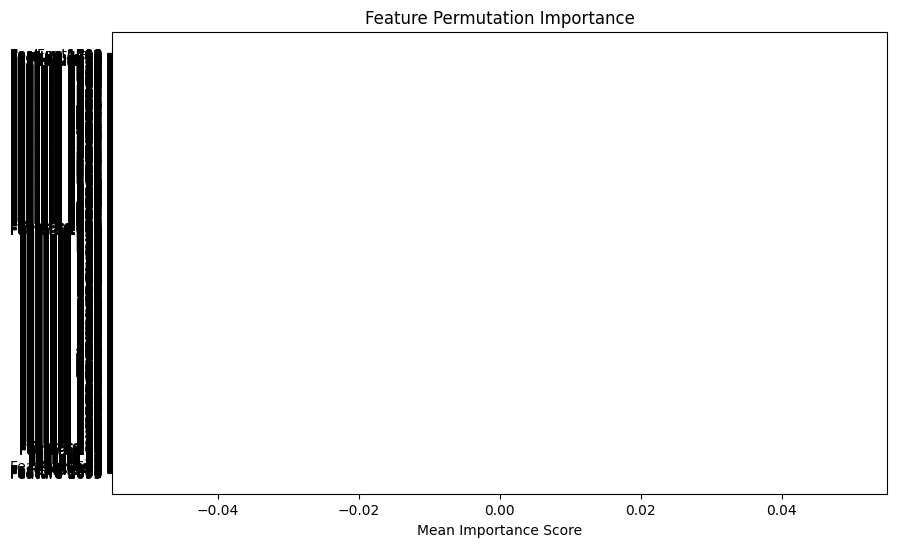

In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
import numpy as np
import torch
import matplotlib.pyplot as plt

# Move test data to CPU and flatten
X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0], -1)  # Flatten sequences
y_test_np = y_test.cpu().numpy()

# Define model wrapper for Sklearn compatibility
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def fit(self, X, y):
        pass  # No need to fit again

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32, device="cpu").view(X.shape[0], 90, 19)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy().flatten()  # Ensure correct shape
        return (preds > self.threshold).astype(int)  # Convert to binary labels


wrapped_model = SklearnWrapper(model)

# Compute permutation importance
perm_importance = permutation_importance(wrapped_model, X_test_np, y_test_np, n_repeats=10, random_state=42)

# Plot feature importance
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]  # Sort by importance

plt.figure(figsize=(10, 6))
plt.barh([f"Feature {i}" for i in sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Mean Importance Score")
plt.title("Feature Permutation Importance")
plt.gca().invert_yaxis()
plt.show()
